In [8]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: white;
}
</style>

In [32]:
# </path/to>/build/bin/hipace <input>

import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from openpmd_viewer import OpenPMDTimeSeries
from openpmd_viewer.addons import LpaDiagnostics
from scipy import constants

from matplotlib import patches
from matplotlib import ticker

import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import ConnectionPatch

import sys
sys.path.append('/Users/max/HiPACE/src/hipace/tools/')
import read_insitu_diagnostics as diag

plt.rc('text', usetex = True)
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.figsize'] = [10.0, 6.0]
plt.rcParams['font.size'] = 16
plt.style.use('classic')

####################################################################################################
ncolors = 256
color_array1 = plt.get_cmap('RdBu')(range(ncolors))
color_array2 = plt.get_cmap('PuOr')(range(ncolors))
color_array3 = plt.get_cmap('PRGn')(range(ncolors))
color_array4 = plt.get_cmap('bwr')(range(ncolors))

# change alpha values
color_array1[:,-1] = abs(np.linspace(-.95, .95, ncolors))
color_array2[:,-1] = abs(np.linspace(-1.0, 1.0, ncolors))
color_array3[:,-1] = abs(np.linspace(-1.0, 1.0, ncolors))
color_array4[:,-1] = abs(np.linspace(-1.0, 1.0, ncolors))

# create a colormap object
map_object1 = mcolors.LinearSegmentedColormap.from_list(name = 'RdBuT', colors = color_array1)
map_object2 = mcolors.LinearSegmentedColormap.from_list(name = 'PuOrT', colors = color_array2)
map_object3 = mcolors.LinearSegmentedColormap.from_list(name = 'PRGnT', colors = color_array3)
map_object4 = mcolors.LinearSegmentedColormap.from_list(name = 'bwrT', colors = color_array4)

# register this new colormap with matplotlib
# plt.register_cmap(cmap = map_object1)
# plt.register_cmap(cmap = map_object2)
# plt.register_cmap(cmap = map_object3)
# plt.register_cmap(cmap = map_object4)
####################################################################################################

# di = 'long'
# di = 'short'
# di = 'mix'
# di = 'salame'
# di = 'salameWitness'
# di = 'loaded'
di = 'recoveryPositron'

ts = LpaDiagnostics('/Users/max/HiPACE/recovery/diags/hdf5/recovery/' + di + '/', check_all_files = True)
# ts = LpaDiagnostics('/Users/max/HiPACE/recovery/diags/hdf5/salame/', check_all_files = True)

prof = {'drive': [[0, 1.41]], 'witness': [[-11.57, .5], [-11.3, .2]], 'recovery': [[-17.5, 0.3525]]}
# prof = {'drive': [[0, 1.41]], 'witness': [[-11.57, .5], [-11.3, .2]], 'recovery': [[-17.5, .705]]}

n0 = 1e17 # cm^-3

In [33]:
def skinDepth(ne):
    """
    Calculates plasma skin depth based off plasma electron density

    Parameters
    ----------
    ne : float
        plasma electron density (in cm^-3)
    
    Returns
    -------
    kp_inv : float
        plasma skin depth in m
    """

    wp = 1e-3 * np.sqrt((ne * constants.e**2) / (constants.epsilon_0 * constants.m_e)) # SI
    
    kp_inv = 1e-6 * constants.c / wp # m
    
    return kp_inv

def E0(ne: float) -> float:
    """
    Calculates the cold-nonrelativistic wave breaking field E0

    Parameters
    ----------
    ne : float
        plasma electron density (in cm^-3)
    
    Returns
    -------
    E0 : float
        cold-nonrelativistic wave breaking field (in V/m)
    """
    kp = skinDepth(ne) ** -1 # m^-1
    return constants.m_e * constants.c**2 * kp / constants.e # V/m

def getZ(E, info):
    """
    returns on-axis longitudinal slice of field
    """
    return E[:, len(info.x)//2, len(info.x)//2].T

def getPlotData(iteration: int = 0) -> tuple:
    i = iteration

    ExmBy, info = ts.get_field(field = 'ExmBy', iteration = i)
    Ez = getZ(ts.get_field(field = 'Ez', iteration = i)[0], info)
    xd, zd = ts.get_particle(species = 'drive', iteration = i, var_list = ['x', 'z'])
    xw, zw, ww = ts.get_particle(species = 'witness', iteration = i, var_list = ['x', 'z', 'w'])
    xw2, zw2, ww2 = ts.get_particle(species = 'witness2', iteration = i, var_list = ['x', 'z', 'w'])
    # xw2, zw2 = [0, 0]
    xr, zr, wr = ts.get_particle(species = 'recovery', iteration = i, var_list = ['x', 'z', 'w'])

    return ExmBy, info, Ez, xd, zd, xw, zw, ww, xw2, zw2, ww2, xr, zr, wr

def gaussian(x, mu, sigma):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * sigma**2))

def gaussianA(x, mu, sigma, A):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def EDensitySim(n0, iteration = 0, xyz = False):
    """
    From HiPACE++ simulation (normalized input file)
    """
    
    i = iteration

    Ez, info = ts.get_field(field = 'Ez', iteration = i)
    ExmBy, _ = ts.get_field(field = 'ExmBy', iteration = i)
    EypBx, _ = ts.get_field(field = 'EypBx', iteration = i)
    By, _ = ts.get_field(field = 'By', iteration = i)
    Bx, _ = ts.get_field(field = 'Bx', iteration = i)
    Bz, _ = ts.get_field(field = 'Bz', iteration = i)

    Ex = ExmBy + By
    Ey = EypBx - Bx
    
    # 1 / (µ0 c^2) = epsilon0

    # u = E0(n0)**2 / 2 * (constants.epsilon_0 * (Ex**2 + Ey**2 + Ez**2) + 1 / (constants.mu_0 * constants.c**2) * (Bx**2 + By**2 + Bz**2)) # from normalized sim
    u = E0(n0)**2 / 2 * constants.epsilon_0 * ((Ex**2 + Ey**2 + Ez**2) + (Bx**2 + By**2 + Bz**2)) # from normalized sim
    
    if xyz:
        return info, u
    else:
        return u

def charge(q: float, ne = 1e23) -> float:
    """
    Calculates charge in Coulombs based off of normalized charge

    Parameters
    ----------
    q : float
        normalized charge
    ne : float
        plasma electron density (in m^-3).  Defaults to 1e23 m^-3

    Returns
    -------
    q0 * q : float
        charge in Coulombs
    """
    # n_b = Q/((2*pi)^(3/2)* std_x * std_y * std_z)
    
    q0 = constants.c**3 * constants.epsilon_0**(3/2) * constants.m_e**(3/2) / (np.sqrt(ne) * constants.e**2)
    
    return q0 * q

def bunchMask(recovery = False, iteration = 0) -> tuple:
    i = iteration
    _, info = ts.get_field(field = 'Ez', iteration = i, coord = 'z')
    zd = ts.get_particle(species = 'drive', iteration = i, var_list = ['z'])[0]
    zw = ts.get_particle(species = 'witness', iteration = i, var_list = ['z'])[0]

    driveMin, driveMax = min(zd), max(zd)
    witnessMin, witnessMax = min(zw), max(zw) # note that 'witness2' is spatially contained in 'witness'

    maskD = np.logical_and(driveMin <= info.z, info.z <= driveMax)
    maskW = np.logical_and(witnessMin <= info.z, info.z <= witnessMax)

    if recovery:
        zr = ts.get_particle(species = 'recovery', iteration = i, var_list = ['z'])[0]
        recoveryMin, recoveryMax = min(zr), max(zr)
        maskR = np.logical_and(recoveryMin <= info.z, info.z <= recoveryMax)
    else:
        maskR = np.zeros_like(maskD)

    return maskD, maskW, maskR

def efficiency(path: str, profile: dict = None, iteration = 0, check_files = False) -> float:
    """
    Calculates energy transfer efficiency from drive to witness bunch.

    Parameters
    ----------
    path : str
        path to output directory

    profile : dict
        profile of the bunches takes on the following form (assuming the bunches are formed by gaussians)
            {'drive': [[mu1, sigma1], [mu2, sigma2], ...], 'witness': [[mu1, sigma1], [mu2, sigma2], ...]}
        If None, then a histogram of each bunch profile is used to calculate energy transfer efficiency.
    
    iteration : int, optional
        iteration number. Defaults to 0.
    
    check_files :bool, optional
        check all files in directory are of the same form. Defaults to False.

    Returns
    -------
    eta : float (in percent)
        energy transfer efficiency from drive to witness bunch
    """

    ts = LpaDiagnostics(path, check_all_files = check_files)

    i = iteration

    Qd = charge(ts.get_charge(species = 'drive', iteration = i))
    Qw = charge(ts.get_charge(species = 'witness', iteration = i) + ts.get_charge(species = 'witness2', iteration = i))

    Ez_raw, info = ts.get_field(field = 'Ez', iteration = i, coord = 'z')
    _, zd = ts.get_particle(species = 'drive', iteration = i, var_list = ['x', 'z'])
    _, zw = ts.get_particle(species = 'witness', iteration = i, var_list = ['x', 'z'])
    _, zw2 = ts.get_particle(species = 'witness2', iteration = i, var_list = ['x', 'z'])

    Ez = getZ(Ez_raw, info) # on-axis slice of Ez

    driveMin, driveMax = min(zd), max(zd)
    witnessMin, witnessMax = min(zw), max(zw) # note that 'witness2' is spatially contained in 'witness'

    maskD = np.logical_and(driveMin <= info.z, info.z <= driveMax)
    maskW = np.logical_and(witnessMin <= info.z, info.z <= witnessMax)

    if not profile:
        plt.rcParams['agg.path.chunksize'] = 10000
        profileD = plt.hist(zd, bins = len(Ez[maskD]))[0]
        profileW = plt.hist(np.concatenate((zw, zw2)), bins = (len(Ez[maskW])))[0]
        plt.close()
    else:
        profileD = np.sum([gaussian(info.z[maskD], *params) for params in profile['drive']], axis = 0)
        profileW = np.sum([gaussian(info.z[maskW], *params) for params in profile['witness']], axis = 0)
    
    EzDAvg = np.average(Ez[maskD], weights = profileD)
    EzWAvg = np.average(Ez[maskW], weights = profileW)
    
    eta = - (Qw * EzWAvg) / (Qd * EzDAvg) * 1e2 # percent

    return eta

def quickEfficiency(path: str, insitu_path: str, iteration = 0, recovery = False, check_files = False, plus = False) -> float:
    """
    Calculates energy transfer efficiency from drive to witness bunch (only uses on-axis slices).

    Parameters
    ----------
    path : str
        path to output directory
    
    insitu_path : str
        path to insitu diagnostics file

    iteration : int, optional
        iteration number. Defaults to 0.
    
    check_files :bool, optional
        check all files in directory are of the same form. Defaults to False.

    Returns
    -------
    eta : float (in percent)
        energy transfer efficiency from drive to witness bunch
    """
    ts = LpaDiagnostics(path, check_all_files = check_files)

    driveInsitu = diag.read_file(insitu_path + 'reduced_drive.0000.txt')
    witnessInsitu = diag.read_file(insitu_path + 'reduced_witness.0000.txt')
    witness2Insitu = diag.read_file(insitu_path + 'reduced_witness2.0000.txt')

    if recovery:
        recoveryInsitu = diag.read_file(insitu_path + 'reduced_recovery.0000.txt')
    else:
        recoveryInsitu = np.zeros_like(driveInsitu)

    if plus:
        s = 1
    else:
        s = -1

    Qd_slices = diag.per_slice_charge(driveInsitu)[0]
    Qw_slices = diag.per_slice_charge(witnessInsitu)[0] + diag.per_slice_charge(witness2Insitu)[0] + s * diag.per_slice_charge(recoveryInsitu)[0]
    # Qw_slices = diag.per_slice_charge(witnessInsitu)[0] + s * diag.per_slice_charge(recoveryInsitu)[0]

    i = iteration

    Ez_raw, info = ts.get_field(field = 'Ez', iteration = i, coord = 'z')
    
    Ez = getZ(Ez_raw, info) # on-axis slice of Ez

    d = Ez @ Qd_slices
    w = Ez @ Qw_slices

    eta = - (w / d) * 1e2 # percent

    return eta

def efficiency3D(path: str, insitu_path: str, iteration = 0, recovery = False, check_files = False, plus = False) -> float:
    """
    Calculates energy transfer efficiency from drive to witness bunch (includes entire 3D domain in calculation).

    NOTE: `diagnostic.names = driver_diag witness_diag` must be set with xyz Ez field diagnostics enabled in order for this to work

    Parameters
    ----------
    path : str
        path to output directory
    
    insitu_path : str
        path to insitu diagnostics file

    iteration : int, optional
        iteration number. Defaults to 0.
    
    check_files :bool, optional
        check all files in directory are of the same form. Defaults to False.

    Returns
    -------
    eta : float (in percent)
        energy transfer efficiency from drive to witness bunch
    """
    
    ts = LpaDiagnostics(path, check_all_files = check_files)
    
    i = iteration

    driveInsitu = diag.read_file(insitu_path + 'reduced_drive.0000.txt')
    witnessInsitu = diag.read_file(insitu_path + 'reduced_witness.0000.txt')
    witness2Insitu = diag.read_file(insitu_path + 'reduced_witness2.0000.txt')

    z = diag.z_axis(driveInsitu)

    EzDrive, infoD = ts.get_field(field = 'Ez_driver_diag', iteration = i)
    EzWitness, infoW = ts.get_field(field = 'Ez_witness_diag', iteration = i)

    if recovery:
        recoveryInsitu = diag.read_file(insitu_path + 'reduced_recovery.0000.txt')
        EzRecovery, infoR = ts.get_field(field = 'Ez_recovery_diag', iteration = i)
        maskR = np.logical_and(z >= infoR.zmin, z <= infoR.zmax)
        EzR = np.array([np.mean(EzRecovery[i,:,:]) for i in range(EzRecovery.shape[0])])
        Qr_slices = diag.per_slice_charge(recoveryInsitu)[0][maskR]
        r = EzR @ Qr_slices
    else:
        r = 0

    # average Ez for each z-slice over each bunch
    EzD = np.array([np.mean(EzDrive[i,:,:]) for i in range(EzDrive.shape[0])])
    EzW = np.array([np.mean(EzWitness[i,:,:]) for i in range(EzWitness.shape[0])])

    maskD = np.logical_and(z >= infoD.zmin, z <= infoD.zmax)
    maskW = np.logical_and(z >= infoW.zmin, z <= infoW.zmax)

    Qd_slices = diag.per_slice_charge(driveInsitu)[0][maskD]
    Qw_slices = (diag.per_slice_charge(witnessInsitu)[0] + diag.per_slice_charge(witness2Insitu)[0])[maskW]

    # print(Qd_slices.shape, Qw_slices.shape, Qr_slices.shape)
    # print(EzD.shape, EzW.shape)

    d = EzD @ Qd_slices
    w = EzW @ Qw_slices

    if plus:
        s = 1
    else:
        s = -1

    eta = - ((w + s * r) / d) * 1e2 # percent

    return eta

def getProfile(iteration = 0):
    """
    NOTE: Assumes fixed particle weights
    """
    i = iteration
    maskD, maskW, maskR = bunchMask(recovery = True, iteration = i)

    Ez_raw, info = ts.get_field(field = 'Ez', iteration = i, coord = 'z')
    Ez = getZ(Ez_raw, info) # on-axis slice of Ez
    zd, wd = ts.get_particle(species = 'drive', iteration = i, var_list = ['z', 'w'])
    zw, ww = ts.get_particle(species = 'witness', iteration = i, var_list = ['z', 'w'])
    zw2, ww2 = ts.get_particle(species = 'witness2', iteration = i, var_list = ['z', 'w'])
    # zw2 = []
    zr, wr = ts.get_particle(species = 'recovery', iteration = i, var_list = ['z', 'w'])

    plt.close()
    plt.figure(figsize = (10, 6))
    plt.rcParams['agg.path.chunksize'] = 10000
    nD = plt.hist(zd, bins = len(Ez[maskD]), facecolor = 'r', linewidth = 0.2, weights = wd)[0]
    nW = plt.hist(np.concatenate((zw, zw2)), bins = (len(Ez[maskW])), facecolor = 'b', linewidth = 0.2, weights = np.concatenate((ww, ww2)))[0]
    nR = plt.hist(zr, bins = (len(Ez[maskR])), facecolor = 'g', linewidth = 0.2, weights = wr)[0]

    plt.plot(info.z[maskD], nD, 'k--')
    plt.plot(info.z[maskW], nW, 'k--')
    plt.plot(info.z[maskR], nR, 'k--')

    plt.close()

    return nD, info.z[maskD], nW, info.z[maskW], nR, info.z[maskR]





In [34]:
i = 0

In [35]:
ExmBy, info, Ez, xd, zd, xw, zw, ww, xw2, zw2, ww2, xr, zr, wr = getPlotData(iteration = i)

maskD, maskW, maskR = bunchMask(recovery = True, iteration = i)
profileD, xD, profileW, xW, profileR, xR = getProfile(iteration = i)

ptsW, bnW, _ = plt.hist(zw, bins = len(Ez[maskW]), weights = ww)
pts, bn, _ = plt.hist(zr, bins = len(Ez[maskR]), weights = wr)
plt.close()
centersW = 0.5 * (bnW[1:] + bnW[:-1])
centers = 0.5 * (bn[1:] + bn[:-1])

# end at zero for vieweing purposes
centersW = np.insert(centersW, 0, bnW[0])
ptsW = np.insert(ptsW, 0, 0);
centers = np.insert(centers, 0, bn[0])
pts = np.insert(pts, 0, 0);

# profileD = np.sum([gaussian(info.z[maskD], *params) for params in prof['drive']], axis = 0)
# profileW = np.sum([gaussian(info.z[maskW], *params) for params in prof['witness']], axis = 0)
# profileR = np.sum([gaussian(info.z[maskR], *params) for params in prof['recovery']], axis = 0)

rho, _ = ts.get_field(field = 'rho', iteration = i, coord = 'z')
jz_beam, _ = ts.get_field(field = 'jz_beam', iteration = i, coord = 'z')

In [37]:
pos = False

# pQuick = '/Users/max/HiPACE/recovery/diags/hdf5/salame/'
# ipQuick = '/Users/max/HiPACE/recovery/diags/insitu/salame/'
pQuick = '/Users/max/HiPACE/recovery/diags/hdf5/recovery/' + di + '/'
ipQuick = '/Users/max/HiPACE/recovery/diags/insitu/recovery/' + di + '/'

p = '/Users/max/HiPACE/recovery/diags/hdf5/efficiency/' + di + '/'
ip = '/Users/max/HiPACE/recovery/diags/insitu/efficiency/' + di + '/'

# print(f'(Manual) Energy Transfer Efficiency : {efficiency(path = pQuick, profile = prof):.2f} %')

print(f'(Quick) Energy Transfer Efficiency : {quickEfficiency(pQuick, ipQuick, iteration = i, recovery = True, plus = pos):.2f} %')
# print(f'(3D) Energy Transfer Efficiency : {efficiency3D(p, ip, iteration = i, recovery = True, plus = pos):.2f} %')

(Quick) Energy Transfer Efficiency : 3.38 %


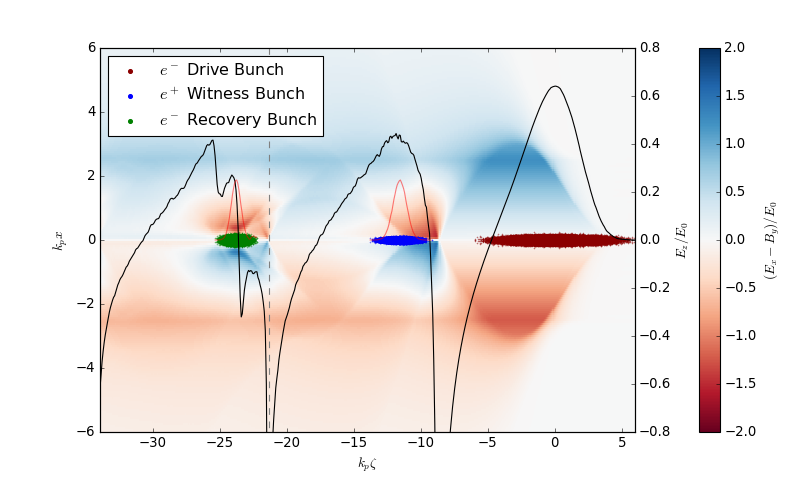

In [38]:
plt.close()
plt.figure(figsize = (10, 6))
ax = plt.axes()

im = plt.pcolormesh(info.z, info.x, ExmBy[:, len(info.x)//2].T, cmap = 'RdBu', vmin = -2, vmax = 2)
# plt.pcolormesh(info.z, info.x, np.transpose(jz_beam[:, len(info.x)//2]), cmap = 'RdBuT', vmin = -1e2, vmax = 1e2)
plt.scatter(zd, xd, s = .02, color = 'darkred', label = '$e^-$ Drive Bunch')
plt.scatter(zw, xw, s = .02, color = 'b', label = '$e^+$ Witness Bunch')
plt.scatter(zw2, xw2, s = .02, color = 'b', label = '__nolegend__')
plt.scatter(zr, xr, s = .02, color = 'g', label = '$e^-$ Recovery Bunch')

plt.xlim(info.zmin, info.zmax)
# plt.ylim(info.xmin, info.xmax)
plt.ylim(-6, 6)
plt.ylabel('$k_px$')
plt.xlabel('$k_p\zeta$')
leg = plt.legend(scatterpoints = 1, loc = 'upper left', markerscale = 25)
leg.remove()

ax2 = plt.twinx()
ax2.plot(info.z, Ez, color = 'black')
ax2.set_ylim(-.8, .8)
ax2.set_ylabel(r'$E_z/E_0$',  labelpad = 1) 
ax2.add_artist(leg)

# o = 0.
# ax2.plot(xD, .3 * profileD / max(profileD) + o, 'k--')
# ax2.plot(xW, .25 * profileW / max(profileW) + o, 'k-')
# ax2.plot(xR, .3 * profileR / max(profileR) + o, 'k--')

# profileR = np.sum([gaussian(info.z[maskR], *params) for params in prof['recovery']], axis = 0)
# ax2.plot(xR, .3 * profileR / max(profileR) + o, 'r--')
# plt.hlines(o, info.zmin, info.zmax, color = 'gray', linestyle = '--')

plt.plot(centers, .25 * pts / max(pts), c = 'r', ls = '-', alpha = .5)
plt.plot(centersW, .25 * ptsW / max(ptsW), c = 'r', ls = '-', alpha = .5)
plt.vlines(-21.3046875, info.xmin, info.xmax, color = 'gray', linestyle = '--')

divider2 = make_axes_locatable(ax)
cax2 = divider2.append_axes("right", size = "4%", pad = .8)
divider3 = make_axes_locatable(ax2)
cax3 = divider3.append_axes("right", size = "4%", pad = .8)
cax3.remove()

cb2 = plt.colorbar(im, cax = cax2)
cb2.set_label(r'$(E_x - B_y)/E_0 $')
plt.show()

In [71]:
plt.rcParams['agg.path.chunksize'] = 10000
plt.close()
plt.figure(figsize=(10, 6))
pts, bn, _ = plt.hist(zr, bins = len(Ez[maskR]), weights = wr)
plt.close()
centers = 0.5 * (bn[1:] + bn[:-1])
plt.plot(centers, pts, 'r--')
# plt.show()
plt.close()

In [58]:
tsal = LpaDiagnostics('/Users/max/HiPACE/recovery/diags/hdf5/salame/', check_all_files = True)

In [79]:
zr, wr = tsal.get_particle(species = 'recovery', iteration = i, var_list = ['z', 'w'])

In [ ]:
tsal.slider(cmap = 'RdBu')

In [8]:
u = EDensitySim(n0, iteration = i, xyz = False)

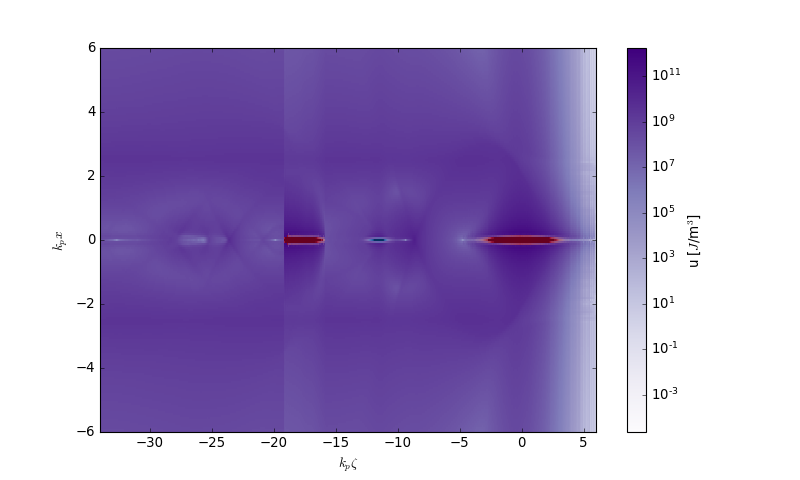

In [11]:
plt.close()
plt.figure(figsize = (10, 6))
img = plt.pcolormesh(info.z, info.x, np.transpose(u[:, len(info.x)//2]), cmap = 'Purples', norm = matplotlib.colors.LogNorm()) #, vmin = 0, vmax = 2.5e4) # y-slice
plt.pcolormesh(info.z, info.x, np.transpose(jz_beam[:, len(info.x)//2]), cmap = 'RdBuT', vmin = -1e2, vmax = 1e2)
# img = plt.pcolormesh(info.z, info.y, np.transpose(u[:, :, len(info.x)//2]), cmap = 'Reds', vmin = 0, vmax = 2.5e4) # x-slice
# img = plt.pcolormesh(info.x, info.y, np.transpose(u[len(info.x)//2, :, :]), cmap = 'Reds', vmin = 0, vmax = 2.5e4) # z-slice

plt.xlim(-34, 6)
# plt.ylim(info.xmin, info.xmax)
plt.ylim(-6, 6)
plt.ylabel('$k_px$')
plt.xlabel('$k_p\zeta$')

cb2 = plt.colorbar(img)
cb2.set_label(r'u [$J$/m$^3$]')

plt.show()

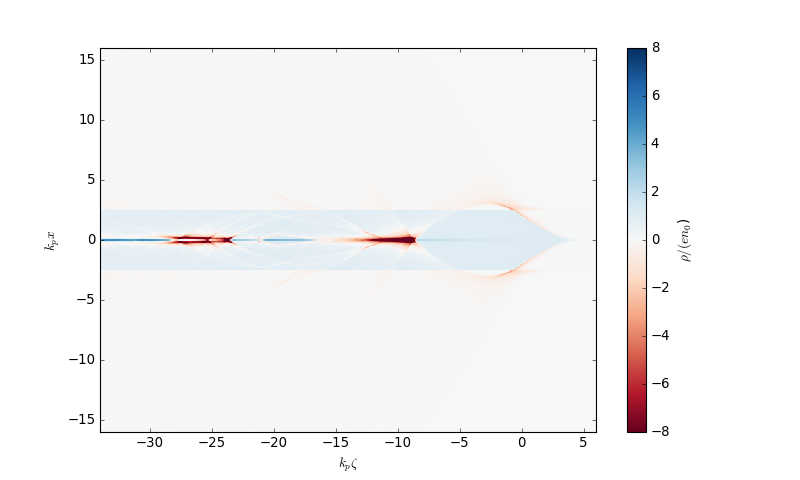

In [17]:
plt.close()
plt.figure(figsize = (10, 6))

# img = plt.pcolormesh(info.z, info.x, np.transpose(jz_beam[:, len(info.x)//2]), cmap = 'RdBu', vmin = -1e2, vmax = 1e2)
img = plt.pcolormesh(info.z, info.x, np.transpose(rho[:, len(info.x)//2]), cmap = 'RdBu', vmin = -8, vmax = 8) # y-slice
# plt.pcolormesh(info.z, info.x, np.transpose(jz_beam[:, len(info.x)//2]), cmap = 'PRGnT', vmin = -1e2, vmax = 1e2)
# img = plt.pcolormesh(info.z, info.y, np.transpose(u[:, :, len(info.x)//2]), cmap = 'Reds', vmin = 0, vmax = 2.5e4) # x-slice
# img = plt.pcolormesh(info.x, info.y, np.transpose(u[len(info.x)//2, :, :]), cmap = 'Reds', vmin = 0, vmax = 2.5e4) # z-slice

plt.xlim(-34, 6)
plt.ylim(-16, 16)
# plt.ylim(-6, 6)
plt.ylabel('$k_px$')
plt.xlabel('$k_p\zeta$')

cb2 = plt.colorbar(img)
cb2.set_label(r'$\rho/(en_0$)')

plt.show()

In [7]:
m = (info.z > -22) & (info.z < -18)
recoveryPlacement = np.argmin(Ez[m])
print(info.z[m][recoveryPlacement])

-21.3046875


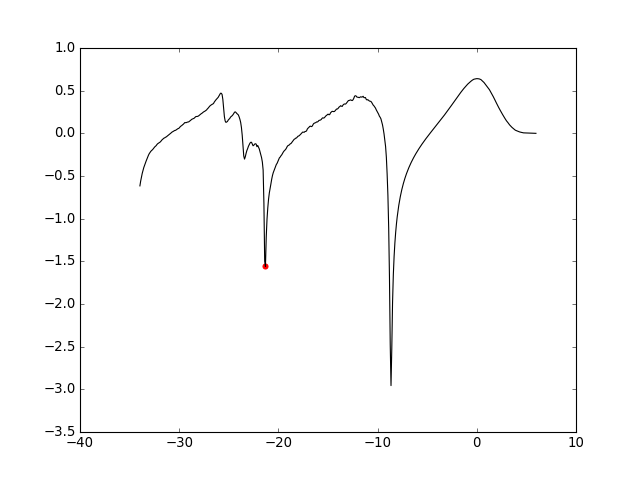

In [8]:
plt.figure()
plt.plot(info.z, Ez, color = 'k')
plt.scatter(info.z[m][recoveryPlacement], Ez[m][recoveryPlacement], color = 'r')
plt.show()